# CIS 5450 Final Project: Startup Investment Analysis

<ins>**Group Members**</ins>: Hye-Jin Kang, Razaq Aribidesi, William Chan

There are thousands of startups that are created yearly, especially at an institution such as Penn. It would be interesting to gain a better understanding of the different factors that go into creating a successful one and to achieve more objective insights into the startup world.

The aim of our project is to analyze the relationship between various startup metrics and their success/funding achieved. We utilize attributes such as target market, number of funding rounds, time founded and location of the various startups in the startup database below. Our ultimate objective is to gain a better understanding of what qualities successful startups have; starting a business is typically a risky decision filled with chance and coincidences, but by using past data, we can see what businesses typically achieve funding and what markets are attractive to investors, making the process a little more certain. In order to accomplish these goals, we've engineered a predictive model that can take in various inputs such as a given startup's market or location and output the expected amount of funding they will get based on historical data.

We want to use data to make these uncertain endeavors into the business world more transparent and reliable. More information regarding the dataset we're using can be found at the following link: https://www.kaggle.com/datasets/justinas/startup-investments?select=objects.csv

## Setting up our data
Before we begin any sort of data analysis or modeling, we first import the required packages and our dataset from Kaggle, as seen below.

In [ ]:
#import packages 
import json
import glob
import pandas as pd
import numpy as np
import datetime as dt
import re
import os
import matplotlib.pyplot as plt
import seaborn as sns
from matplotlib import cm
from google.colab import drive
from sklearn.model_selection import train_test_split
from collections import Counter
import seaborn as sns

In [ ]:
%%capture
!apt update
!pip install kaggle

In [ ]:
#reading data 
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
!mkdir ~/.kaggle

In [ ]:
!cp /content/drive/MyDrive/kaggle.json ~/.kaggle/

In [ ]:
!!kaggle datasets download -d justinas/startup-investments

['Downloading startup-investments.zip to /content',
 '',
 '  0% 0.00/115M [00:00<?, ?B/s]',
 '  8% 9.00M/115M [00:00<00:01, 81.3MB/s]',
 ' 23% 27.0M/115M [00:00<00:00, 140MB/s] ',
 ' 37% 42.0M/115M [00:00<00:00, 143MB/s]',
 ' 50% 57.0M/115M [00:00<00:00, 125MB/s]',
 ' 63% 73.0M/115M [00:00<00:00, 137MB/s]',
 ' 80% 92.0M/115M [00:00<00:00, 154MB/s]',
 ' 94% 108M/115M [00:00<00:00, 152MB/s] ',
 '',
 '100% 115M/115M [00:00<00:00, 144MB/s]']

In [ ]:
!unzip /content/startup-investments.zip

Archive:  /content/startup-investments.zip
  inflating: acquisitions.csv        
  inflating: degrees.csv             
  inflating: funding_rounds.csv      
  inflating: funds.csv               
  inflating: investments.csv         
  inflating: ipos.csv                
  inflating: milestones.csv          
  inflating: objects.csv             
  inflating: offices.csv             
  inflating: people.csv              
  inflating: relationships.csv       


In [ ]:
# Storing csv files as pandas dataframes
objects_df = pd.read_csv('objects.csv')
people_df = pd.read_csv('objects.csv')
funding_rounds_df = pd.read_csv('funding_rounds.csv')
acquisitions_df = pd.read_csv('acquisitions.csv')
offices_df = pd.read_csv('offices.csv')
degrees_df = pd.read_csv('degrees.csv')

<ipython-input-8-ce1bf66117cf>:2: DtypeWarning: Columns (3,7,9,10,17,18,21,22,23,25,26,29,30,37) have mixed types. Specify dtype option on import or set low_memory=False.
  objects_df = pd.read_csv('objects.csv')
<ipython-input-8-ce1bf66117cf>:3: DtypeWarning: Columns (3,7,9,10,17,18,21,22,23,25,26,29,30,37) have mixed types. Specify dtype option on import or set low_memory=False.
  people_df = pd.read_csv('objects.csv')


## Exploratory Data Analysis (EDA)
In order to gain a better understanding of just what kind of data we're working with, we can do some exploratory data analysis, gaining more information about the dataset as a whole and creating some useful visualizations regarding how different variables individually affect things like startup funding or continued operation.

Before we start working with our data, we can clean it to be less cluttered, only keeping the variables that we are interested in. Below, objects_cleaned_df is a database containing infomration on the given startup's company name and the ceo/founder behind it.  

In [ ]:
objects_cleaned_df = objects_df[["entity_id", "category_code", "status", "name", "founded_at", "state_code", 'funding_total_usd']]
objects_cleaned_df = objects_cleaned_df.dropna()
objects_cleaned_df['founded_year'] = pd.to_datetime(objects_cleaned_df['founded_at'])
objects_cleaned_df['founded_year'] = objects_cleaned_df['founded_year'].dt.year

<ipython-input-9-440e0a041940>:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  objects_cleaned_df['founded_year'] = pd.to_datetime(objects_cleaned_df['founded_at'])
<ipython-input-9-440e0a041940>:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  objects_cleaned_df['founded_year'] = objects_cleaned_df['founded_year'].dt.year


funding_rounds_cleaned_df holds information on all of the rounds of funding received by each individual startup.

In [ ]:
funding_rounds_cleaned_df = funding_rounds_df[["object_id", "funding_round_code", "raised_amount_usd", 'funding_round_type']]
funding_rounds_cleaned_df = funding_rounds_cleaned_df.dropna()
funding_rounds_cleaned_df['object_id'] = funding_rounds_cleaned_df['object_id'].str.replace('^c:', '', regex=True).astype(int)


In [ ]:
funding_rounds_cleaned_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 52928 entries, 0 to 52927
Data columns (total 4 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   object_id           52928 non-null  int64  
 1   funding_round_code  52928 non-null  object 
 2   raised_amount_usd   52928 non-null  float64
 3   funding_round_type  52928 non-null  object 
dtypes: float64(1), int64(1), object(2)
memory usage: 1.6+ MB


acquisitions_cleaned_df holds information on all of the startups that got acquired and how much they were sold for, along with the currency this price is stored in.

In [ ]:
acquisitions_cleaned_df = acquisitions_df[["acquired_object_id", "price_amount", "price_currency_code"]]
acquisitions_cleaned_df = acquisitions_cleaned_df.dropna()

offices_cleaned_df holds information on all of the startups offices and where they are based in.

In [ ]:
offices_cleaned_df = offices_df[["object_id", "description", "region", "state_code"]]
offices_cleaned_df = offices_cleaned_df.dropna()

We can now dive into the relationship between the company product's category type (in a way the target market) and see if some types of companies tend to earn more funding than others and also see the historical trend of the given market's funding. Before we do this, however, we can take a look at the historical trends of all currently operating startups with the following visualization:

Text(0.5, 1.0, 'Number of Present Operating Startups Per Founded Year')

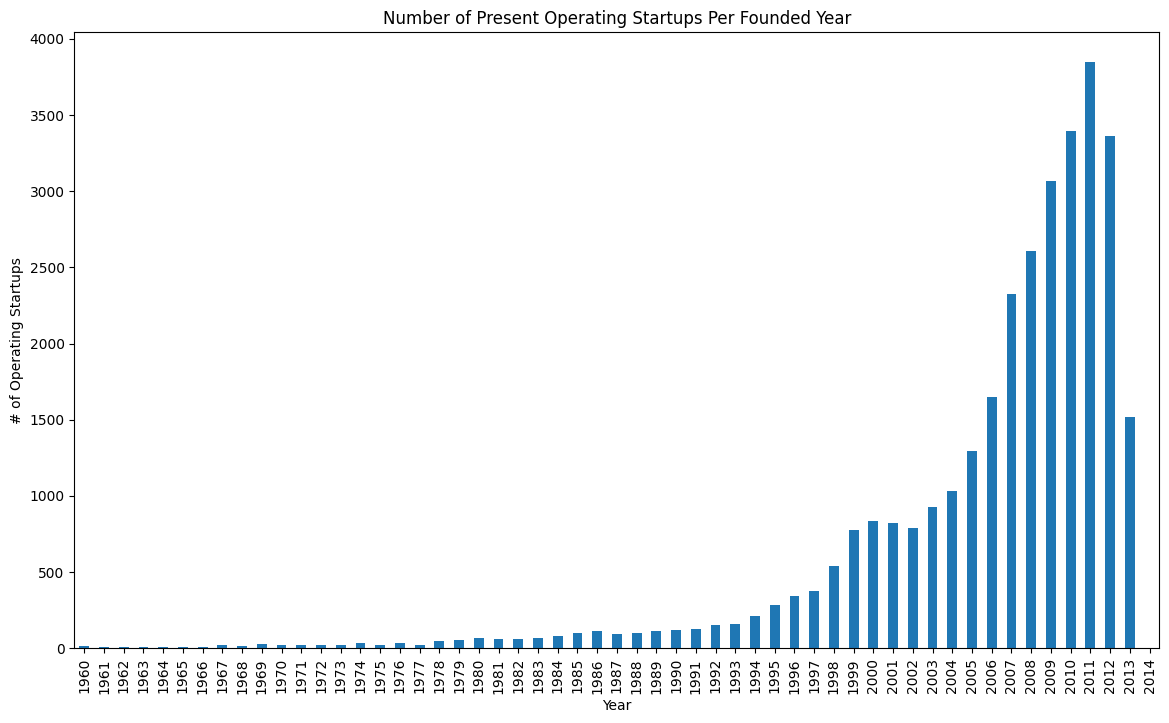

In [ ]:
year_df = objects_cleaned_df[['founded_year', 'status']]
year_df = year_df[year_df['founded_year'] >= 1960]
year_df = year_df.dropna()
year_df = year_df[year_df['status'] == 'operating']
ax = year_df['founded_year'].value_counts()[sorted(year_df.founded_year.unique())].plot(kind='bar',
                                    figsize=(14,8))
plt.xlabel('Year')
plt.ylabel('# of Operating Startups')
plt.title('Number of Present Operating Startups Per Founded Year')

Similarly, the following visualization shows us the total amount of funding going into startups as the years progress:

Text(0.5, 1.0, 'Total Funding in Startup Space Per Year')

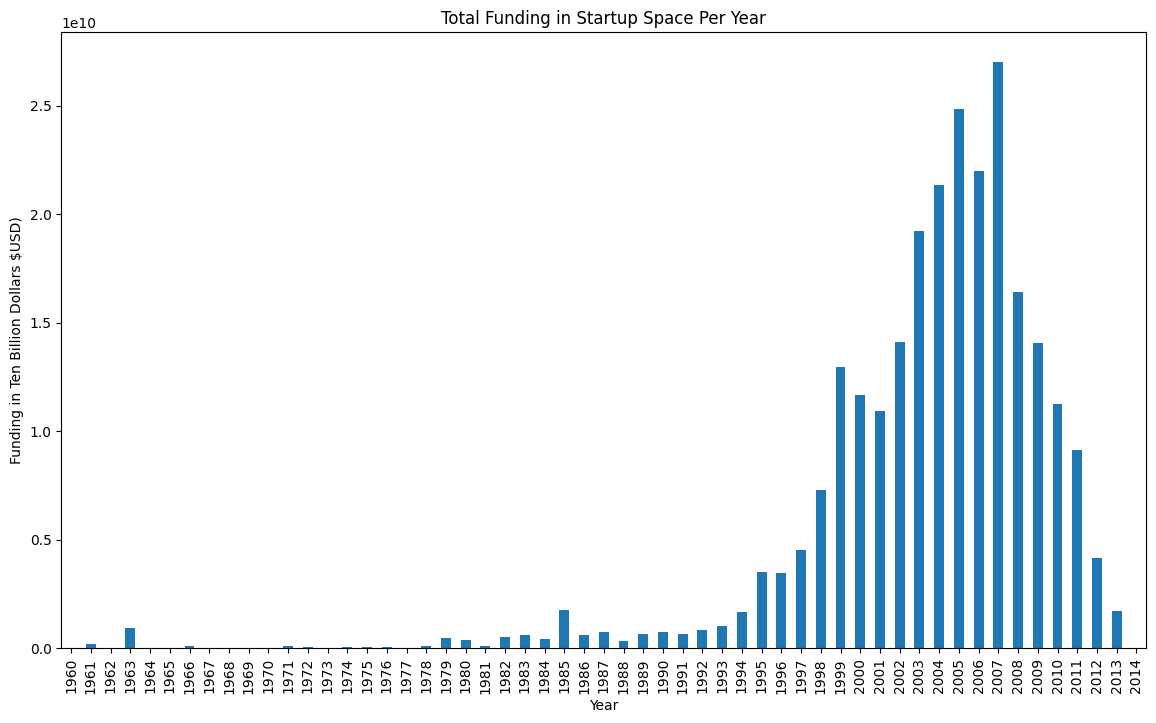

In [ ]:
year_funding = objects_cleaned_df[['founded_year', 'funding_total_usd']]
year_funding = year_funding[year_funding['founded_year'] >= 1960]
year_funding = year_funding.dropna()
year_funding['funding_total_usd'] = year_funding['funding_total_usd'].astype(int)
grouped = year_funding.groupby('founded_year')['funding_total_usd'].sum()
ax3 = grouped.plot(kind='bar', x='founded_year', y='funding_total_usd', figsize=(14,8))
plt.xlabel('Year')
plt.ylabel('Funding in Ten Billion Dollars $USD)')
plt.title('Total Funding in Startup Space Per Year')

Next, we can begin our analysis on different industries and markets that startups are founded in, and visualize historical trends within each individual startup industry. The following is a comprehensive list of what the most common industries are and just how many startups are in each individual market:

In [ ]:
category_keep = objects_cleaned_df[['category_code', 'founded_year']]
category_keep = category_keep.groupby('category_code')['founded_year'].count().reset_index().sort_values(by='founded_year', ascending=False)

category_keep = category_keep.rename(columns={'founded_year': 'count'})

We can now analyze the amount of funding recieved within each industry per year, and visualize it, with the following code.

In [ ]:
category_df = objects_cleaned_df[['category_code','founded_year', 'funding_total_usd']]
category_df['category_code'] = [x if x in category_keep.head(10)['category_code'].tolist() else 'other' for x in category_df['category_code']]
category_df = category_df.groupby(['category_code', 'founded_year'])['funding_total_usd'].mean().reset_index()

<ipython-input-17-804793bd1782>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  category_df['category_code'] = [x if x in category_keep.head(10)['category_code'].tolist() else 'other' for x in category_df['category_code']]


In [ ]:
category_df = category_df[category_df['founded_year']>= 1990]
category_df = category_df.replace(0, np.nan)

In [ ]:
category_df

,category_code,founded_year,funding_total_usd
29,advertising,1990,NaN
30,advertising,1991,1.000000e+07
31,advertising,1992,NaN
32,advertising,1993,NaN
33,advertising,1994,NaN
...,...,...,...
608,web,2009,1.082047e+06
609,web,2010,1.244192e+06
610,web,2011,8.260956e+05
611,web,2012,3.627054e+05


Text(0.5, 1.0, 'Average Funding of Startup of Different Categories Per Year')

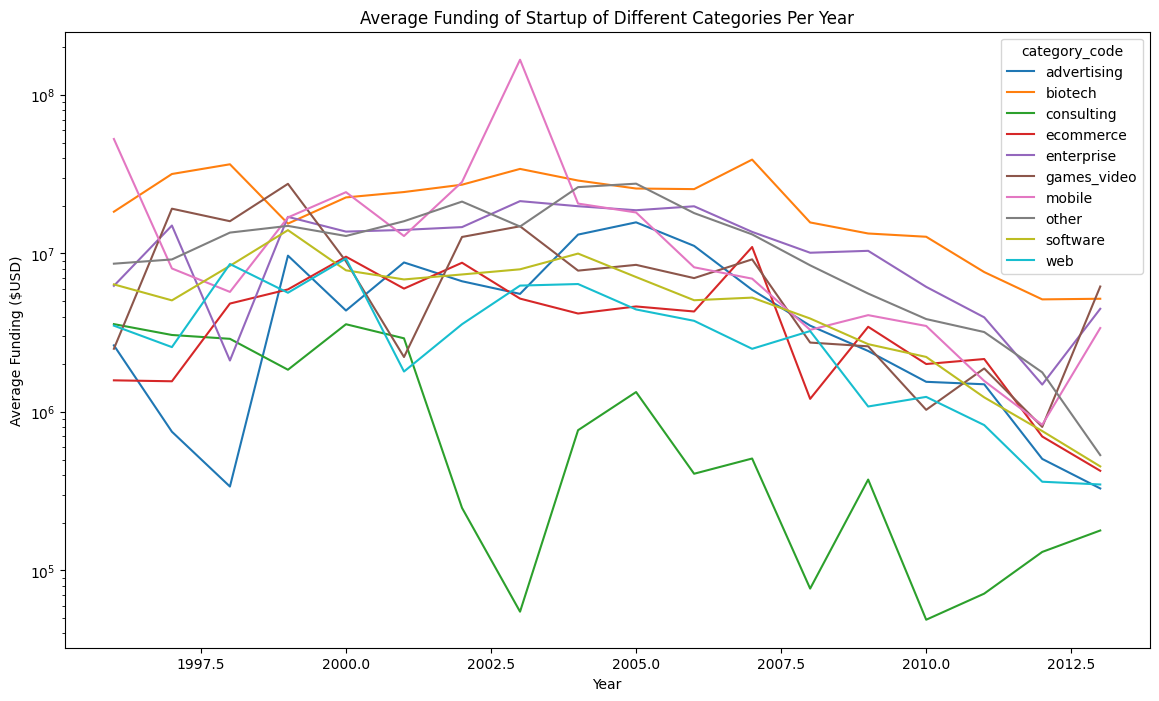

In [ ]:
category_pivot = category_df.pivot(index='founded_year', columns='category_code', values='funding_total_usd').dropna()
category_pivot.plot(figsize=(14,8))
plt.yscale('log')
plt.xlabel('Year')
plt.ylabel('Average Funding ($USD)')
plt.title('Average Funding of Startup of Different Categories Per Year')

Based on this visualization, it seems that the mobile industry has the highest peaks in funding during certain years, while the biotech industry seems to most consistently recieve high levels of funding. Next, we can also analyze the relationship between acquisition and categories as well, as follows:

Text(0.5, 1.0, 'Number of Acquired Startups Per Category')

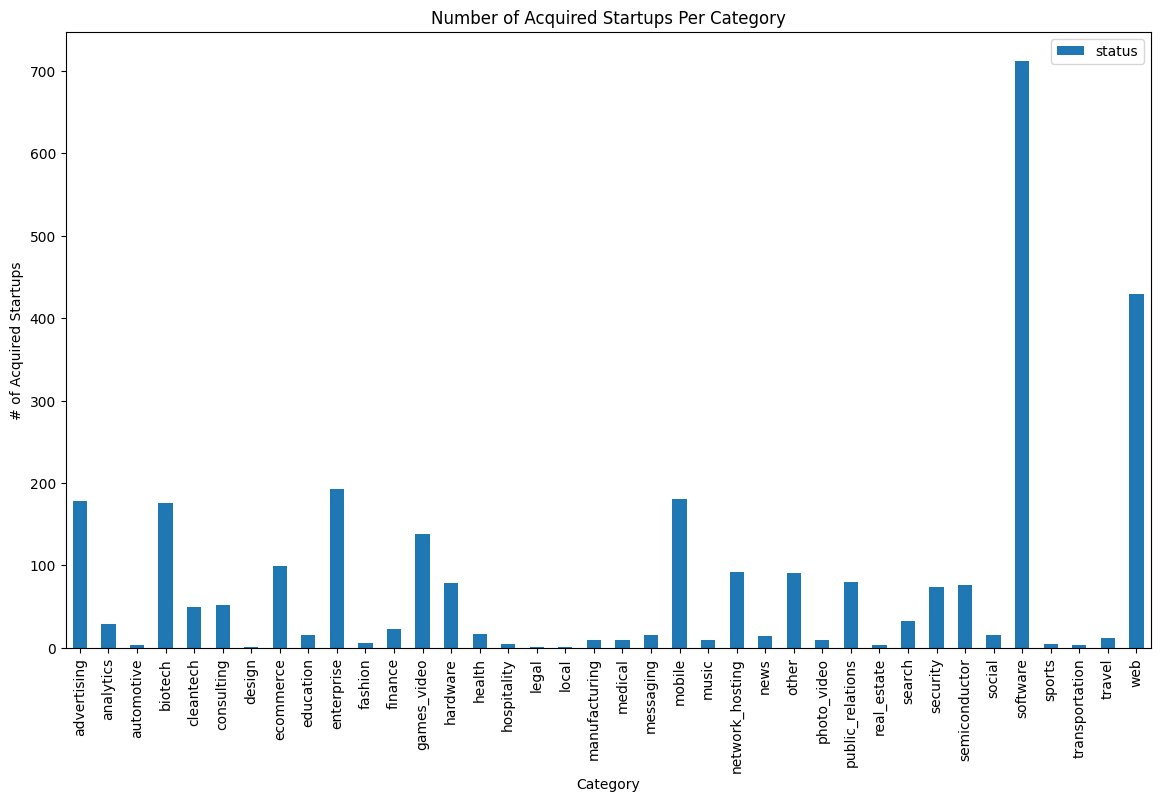

In [ ]:
category_acquisition = objects_cleaned_df[['category_code', 'status']]
category_acquisition = category_acquisition[category_acquisition['status'] == "acquired"]
category_acquisition = category_acquisition.groupby('category_code')["status"].count().reset_index()
category_acquisition.plot(kind='bar', x='category_code', y='status', figsize=(14,8))
plt.xlabel('Category')
plt.ylabel('# of Acquired Startups')
plt.title('Number of Acquired Startups Per Category')

In addition to analyzing startups by industries, we can also visualize how certain states perform in terms of startup funding received. The following chart clearly shows an extremely disproportionate amount of startups being located in California, while New York, Boston, Texas, and Washington also see a significant amount of funding compared to the rest of the states.

Text(0.5, 1.0, 'Total Startup Funding Per State')

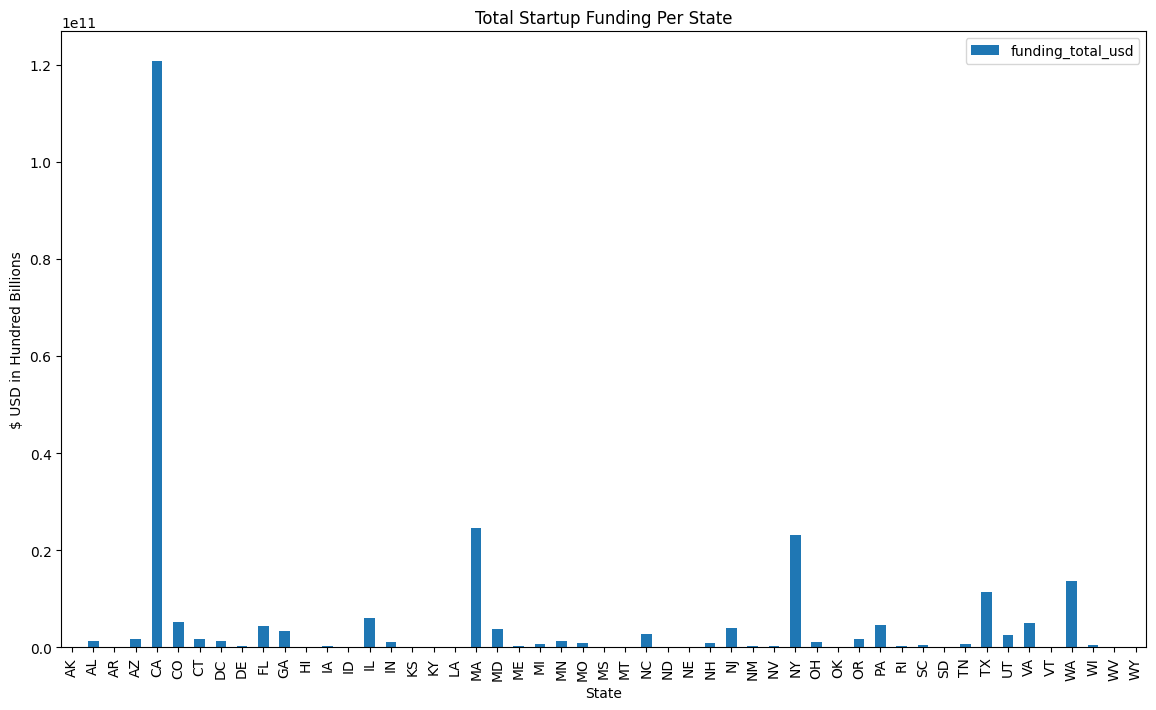

In [ ]:
state_funding = objects_cleaned_df[["state_code", 'funding_total_usd']]
state_funding = state_funding.dropna()
state_funding['funding_total_usd'] = state_funding['funding_total_usd'].astype(int)
grouped2 = state_funding.groupby('state_code')['funding_total_usd'].sum().reset_index()
grouped2 = grouped2[grouped2['funding_total_usd'] > 0]
ax3 = grouped2.plot(kind='bar', x='state_code', y='funding_total_usd', figsize=(14,8))
plt.xlabel('State')
plt.ylabel('$ USD in Hundred Billions')
plt.title('Total Startup Funding Per State')

Now that we have explored the correlation between a startup's product category and it's success, let us explore the possible relationship between company CEO/founders and the success of their companies.

We will first clean the degrees_df to contain only the columns we are interested in.

In [ ]:
degrees_cleaned_df = degrees_df[['object_id', 'degree_type', 'subject', 'institution']]

Next, we will find what percent of startups succeed based on the founder's degree. We will define success in this context as companies who have recieved funding at some point and are still in operation or companies that were acquired.

In [ ]:
degree_type_df = degrees_cleaned_df[['object_id', 'degree_type']]
degree_type_df['object_id'] = degree_type_df['object_id'].str.replace('^p:', '', regex=True).astype(int)

degree_type_df = pd.merge(objects_cleaned_df, degree_type_df, left_on='entity_id', right_on='object_id')

<ipython-input-24-00227c21c68a>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  degree_type_df['object_id'] = degree_type_df['object_id'].str.replace('^p:', '', regex=True).astype(int)


In [ ]:
def success(x):
    if x.funding_total_usd <= 0:
        return 0
    elif x.status == 'closed':
      return 0
    else :
      return 1

degree_type_df['success'] = degree_type_df.apply(lambda x: success(x), axis=1)
degree_type_success_df = degree_type_df.groupby('degree_type')['success'].sum().reset_index()
degree_type_total_df = degree_type_df.groupby('degree_type')['success'].count().reset_index()

degree_type_success_df = degree_type_success_df.sort_values('success', ascending=False)



Since there are many obscure degree types present, we will only focus on the most popular degree types: BS, BA, MS, MBA, and PhD

In [ ]:
degree_type_success_df = degree_type_success_df.iloc[:5]

degree_type_success_df = pd.merge(degree_type_success_df, degree_type_total_df, on='degree_type')
degree_type_success_df['percentage'] = degree_type_success_df.apply(lambda row: (row.success_x / row.success_y), axis=1)

Now we can create our graph!

Text(0.5, 1.0, 'Percentage of Successful Startups by Founder Degree Type')

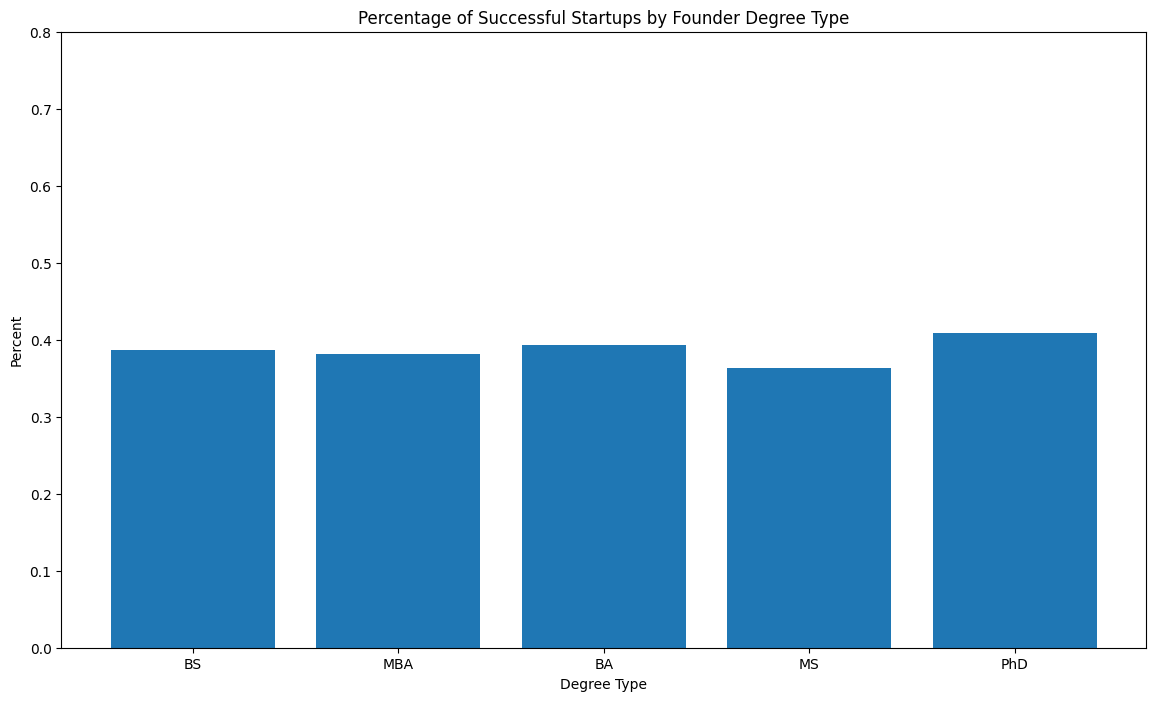

In [ ]:
x = degree_type_success_df['degree_type'].values
y = degree_type_success_df['percentage'].values
plt.figure(figsize=(14, 8))
plt.bar(x, y)
plt.ylim(0, .8)
plt.xlabel('Degree Type')
plt.ylabel('Percent')
plt.title('Percentage of Successful Startups by Founder Degree Type')

As one can see from the bar graph, there does not seem to be a large coorelation between the founder's degree type and the success of the company. All conventional degree types yield around a 40% success rate.
This can inform those who are thinking of starting their own company that they do not need to be complete experts in their field to be successful.


Next, we will find the number of startups that succeed on the basis of the founder's area of study within their schooling. Again will define success in this context as companies who have recieved funding at some point and are still in operation or companies that were acquired.

In [ ]:
major_df = degrees_cleaned_df[['object_id', 'subject']]
major_df['object_id'] = major_df['object_id'].str.replace('^p:', '', regex=True).astype(int)

major_success_df = pd.merge(degree_type_df, major_df, on='object_id')

<ipython-input-28-1914bd288b09>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  major_df['object_id'] = major_df['object_id'].str.replace('^p:', '', regex=True).astype(int)


In [ ]:
major_success_df = major_success_df[['subject', 'success']]
major_success_df = major_success_df.groupby('subject')['success'].sum().reset_index()
major_success_df = major_success_df.sort_values('success', ascending=False)
major_success_df = major_success_df[major_success_df['success'] >= 112]

Text(0.5, 1.0, "Number of Success Startups Grouped by Subject Studied by Founder's Area of Study")

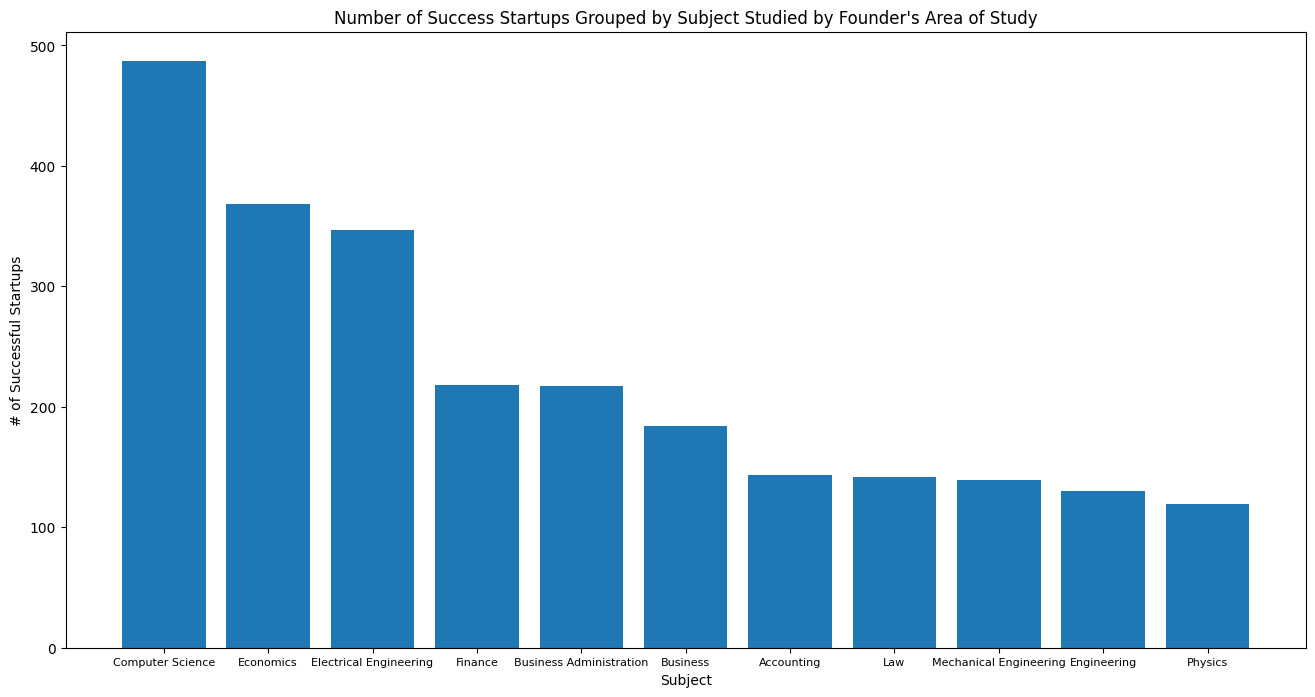

In [ ]:
x = major_success_df['subject'].values
y = major_success_df['success'].values
plt.figure(figsize=(16, 8))
plt.xticks(fontsize=8)
plt.bar(x, y)
plt.xlabel('Subject')
plt.ylabel('# of Successful Startups')
plt.title("Number of Success Startups Grouped by Subject Studied by Founder's Area of Study")

As one can see, the majority of successful startups came from Computer Science majors. The following majors contained a lot of engineering disciplines and also business related majors such as economics and finance. This seems to make sense because a large part of what makes a company succesful is it's product (which many times is the result of engineering) and also it's finances and business sense.
This can inform other potential startup founders whether they could be equipt to start a successful startup based on their academic history.

## Modeling
Now that we have a better idea of what information our dataset consists of, we can continue to analyze our data and predict the success of possible future startups using predictive modeling. We can use sklearn in order to create logistic regression and random forest classifier models with the following code:

In [ ]:
objects_cleaned_df = objects_df[['id', 'entity_id', "country_code", 'funding_total_usd', "status", "state_code", "region", "funding_rounds"]]
objects_cleaned_df.rename(columns = {'entity_id' : 'object_id'}, inplace = True)

<ipython-input-31-b35cb9507c1c>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  objects_cleaned_df.rename(columns = {'entity_id' : 'object_id'}, inplace = True)


In [ ]:
merged_rounds_objects = pd.merge(objects_cleaned_df, funding_rounds_cleaned_df,  how = 'inner',on = 'object_id')

features = merged_rounds_objects[['funding_rounds', 'country_code', 'state_code', 'region']]
target = merged_rounds_objects['status']

features = pd.get_dummies(features, columns = ['country_code', 'state_code', 'region'])
X_train, X_test, y_train, y_test = train_test_split(features, target, test_size=0.2, random_state=42)

In [ ]:
#meant to predict whether startups are successful or not given the above features
from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import accuracy_score, classification_report

scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)


# create the logistic regression model and fit to the training data
lr_model = LogisticRegression()
lr_model.fit(X_train, y_train)

# make predictions on the testing data
y_pred = lr_model.predict(X_test)

# evaluate the performance of the model
log_acc = lr_model.score(X_test, y_test)
accuracy = accuracy_score(y_test, y_pred)
report = classification_report(y_test, y_pred)
print('Acc:')
print('Accuracy:', accuracy)
print('Classification Report:\n', report)

/usr/local/lib/python3.9/dist-packages/sklearn/linear_model/_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/usr/local/lib/python3.9/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.9/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with n

Acc:
Accuracy: 0.8955505926816698
Classification Report:
               precision    recall  f1-score   support

    acquired       0.00      0.00      0.00       968
       alpha       0.00      0.00      0.00         9
        beta       0.00      0.00      0.00        98
      closed       0.00      0.00      0.00       607
 development       0.00      0.00      0.00        26
         ipo       0.60      0.01      0.03       227
        live       0.00      0.00      0.00       474
   operating       0.90      1.00      0.94     20851
     private       0.00      0.00      0.00        24

    accuracy                           0.90     23284
   macro avg       0.17      0.11      0.11     23284
weighted avg       0.81      0.90      0.85     23284



/usr/local/lib/python3.9/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [ ]:
#doing the same thing but with a random forest classifier 
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import confusion_matrix

rf_model = RandomForestClassifier(class_weight = 'balanced', n_estimators=100, random_state=42)
rf_model.fit(X_train, y_train)

#make predictions on the testing data 
y_pred = rf_model.predict(X_test)

#Find accuracy/evaluate performance of the model 
rf_acc = accuracy_score(y_test, y_pred)

#find the confusion matrix 
rf_confusion = confusion_matrix(y_test, y_pred)

In [ ]:
print(rf_acc)
print(rf_confusion)

0.18227108744202028
[[  612     0     0   154     0   136     0    66     0]
 [    0     0     0     0     9     0     0     0     0]
 [    0     0     0     0    98     0     0     0     0]
 [  206     0     0   264    20    52     0    65     0]
 [    0     0     0     0    26     0     0     0     0]
 [   60     0     0    21     0   140     0     6     0]
 [    0     0     0     0   474     0     0     0     0]
 [ 3026     0     0  2105 11251  1267     0  3202     0]
 [    0     0     0     0    24     0     0     0     0]]


In [ ]:
#Test to find the whether a startup would be successful based on the funding amount 
features = merged_rounds_objects[['funding_rounds', 'funding_total_usd']]
target = merged_rounds_objects['status']

# features = pd.get_dummies(features, columns = ['funding_rounds', 'funding_total_usd'])
X_train, X_test, y_train, y_test = train_test_split(features, target, test_size=0.2, random_state=42)

scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)


# create the logistic regression model and fit to the training data
lr_model = LogisticRegression()
lr_model.fit(X_train, y_train)

# make predictions on the testing data
y_pred = lr_model.predict(X_test)

# evaluate the performance of the model
log_acc = lr_model.score(X_test, y_test)
accuracy = accuracy_score(y_test, y_pred)
report = classification_report(y_test, y_pred)

print('Accuracy:', accuracy)
print('Classification Report:\n', report)

/usr/local/lib/python3.9/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Accuracy: 0.8955076447345817
Classification Report:
               precision    recall  f1-score   support

    acquired       0.00      0.00      0.00       968
       alpha       0.00      0.00      0.00         9
        beta       0.00      0.00      0.00        98
      closed       0.00      0.00      0.00       607
 development       0.00      0.00      0.00        26
         ipo       0.00      0.00      0.00       227
        live       0.00      0.00      0.00       474
   operating       0.90      1.00      0.94     20851
     private       0.00      0.00      0.00        24

    accuracy                           0.90     23284
   macro avg       0.10      0.11      0.10     23284
weighted avg       0.80      0.90      0.85     23284



/usr/local/lib/python3.9/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.9/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


##Modeling Conclusion 

Overall we decided to go with two different modeling ideals and we tried two methods initialy. For the first model we aimed to figure out the likelyhood of a startup still succeeding given the location of that startup. In order to do so we did Logistic Regression as well as Random Forest. After using these two methods we noticed that Logistic Regression was significantly better at having a higher accuracy rate compared to Random Forest. This is probably due to the unique charactersitsics of both. Logistic Regression is better whne there may be alot of noise compared to the dataset that you are sampling. Since the files we use have a large amount of datapoints with highly specific differences, it is easy for there to be a lot a noise. Due to this, we then decided to use a Logisitc Regression for the second modeling sample in which we wanted to now find the likelyhood of a startup continuing based on the funding it recieved. 

In these models we decided to not go with a Linear Regression model because we wanted to emphasize more of classification modesl compared to regression models. Classification models are better for incoming startups so that they can have a good idea of where they stand. However, regression models may be better for startups that are further into their lifeline so that they can predict how much they can make. Linear Regression would be better for one individual market or company.  

Overall, these models were able to give us a lot of insight into the success rates of startups given numerous of factors such as the funding they got and the location of their base of operations. Hopefully this data can give people insight so that they can create their startups with ease. 

## Challenges/Obstacles Faced
One challenge we faced in our project was part of our modeling procedure, in which Colab would crash/run out of RAM when running our Machine Learning predictive models. However, connecting to GPU runtime, as well as reducing the number of variables we ran regression on helped to reduce the load on Colab and allowed us to successfully create and run our predictive models.

We also had initially sourced our data form a different kaggle dataframe with similar data, but only around 48k observations, which is a bit less than the required/safe 50k. Additionally, when working on the first dataset in the begining of our project, we quickly learned that the product categories the startups were grouped into were not uniform, with there being over 3,000 unique category types. As the bulk of our data exploration and data analysis relied on analyzing the startup categories, compiling the startup data into more useful category groupings would have had to be done manually, which is a very tedious process. However, the current dataset we hare using now was able to group the startups into more broad categories, with there only being around 40 unique categories in the whole database. This made it easier for us to do our analysis and visualizations. After we found our current dataset, we adapted our code to fit the information presented in this dataset, and were again able to proceed with our EDA and modeling.

## Potential Next Steps
The models used in our project have much room for expansion; the dataset we used, while full of information, also is missing lots of key information about startup businesses, especially with respect to numeric variables. Things like company revenue, company size, and employee salary could provide more fundamental information about different startups and could improve accuracy of our predictions. Additional information would make our models more versatile, as well, allowing for more variables to be accounted for. This, however, would require more data collection, rather than simple analysis, which is currently outside of our current scope. Our predictive models, in their present state, are still very useful though, and we believe that they have helped us accomplish our goal of making the startup process a little more predictable and navigable.

In addition to the possibility of additional variables being incorporated into our models, another possible future step is to apply our predictions into the real world. Finding small, budding startups and seeing if our predictions hold true as time passes could also provide valuable insights on where our model works and where it does not. Available data and ML are ever improving, and although what we've done so far can provide valuable insight into the world of startups, there is always future room for improvement.